# To improve:
* explain notebook

http://localhost:8888/notebooks/Azores/2022-02-14_Azores_simus_tests_20191001_fFTLE_1-64grid_15d.ipynb

In [1]:
#venv py3_parcels
%matplotlib inline
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
from datetime import timedelta, datetime
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

In [2]:
%load_ext version_information
%version_information numpy, xarray, parcels


Software versions
Python 3.6.11 64bit [GCC Clang 11.0.0]
IPython 7.16.1
OS Darwin 21.6.0 x86_64 i386 64bit
numpy 1.19.2
xarray 0.16.2
parcels 2.2.1
Fri Nov 24 15:19:42 2023 CET

In [3]:
outdir = '../examples/'

ds = xr.open_dataset(outdir + 'Particle_AZO_fFTLE_1-64grid_1001_15d.nc')

In [4]:
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import xarray as xr
import numpy.linalg as LA

# Adapted from test03, adding the sqrt in FTLE calcn after discussing with Darshika (this version should be up to date w/ github function!!!
# reorganized filename and savename so easier to modify!!!

def dist_pairs_km(inlon1, inlon2, inlat1, inlat2):
    """
    source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    
    """
    # approximate radius of earth in km
    R = 6373.0

    lon1 = radians(inlon1)
    lat1 = radians(inlat1)
    lon2 = radians(inlon2)
    lat2 = radians(inlat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [5]:
# Parameters:

#Particle_AZO_grid100000_notides_Dec_week01_hourly.nc
grid_name = "1-64grid"
nyear = 2019
nmonth = 10
simu_length = 15. # monthly # days

# Defining grid of starting particles:

if grid_name == "1-8grid":
    step = .125 # degrees
elif grid_name == "1-64grid":
    step = 0.015625 # 1./64degrees
else:
    print("Error")
    fszfasgasg
    
lons, lats = np.meshgrid(np.arange(360.-30, 360.-15+step, step), np.arange(32, 38+step, step))
lons.shape[0]*lons.shape[1]

# data_path = '/Users/Gomez023/Postdoc/data/'
# fname = 'datos_Laura.nc'

369985

In [6]:
Td = simu_length
# step = .004 # degrees
# grid_lons, grid_lats = np.meshgrid(np.arange(-27, -21+step, step), np.arange(32.5, 36.5+step, step))

grid_lons = lons
grid_lats = lats

savedir = outdir
savename = '20191001_fFTLE_1-64grid_15d_CALCS' + '.npz' #savedir + 


In [7]:


######
x0 = np.reshape(ds['lon'][:,0].data, ( grid_lons.shape[0], grid_lons.shape[1] ))
x1 = np.reshape(ds['lon'][:,-1].data,( grid_lons.shape[0], grid_lons.shape[1] ))
y0 = np.reshape(ds['lat'][:,0].data, ( grid_lons.shape[0], grid_lons.shape[1] )) 
y1 = np.reshape(ds['lat'][:,-1].data, ( grid_lons.shape[0], grid_lons.shape[1] ))


H = x0.shape[0] 
L = x0.shape[1]

FTLE_f = np.ones_like(x0) * np.nan

J = np.empty([2,2],float)

# 1, H-1 --> to ignore bordersx for now
for i in range(1, H-1): # 0, H-2
    for j in range(1, L-1): # 0, L-2
        J[0][0] = dist_pairs_km(x1[i,j],x1[i-1,j], y1[i,j],y1[i-1,j]) / dist_pairs_km(x0[i,j],x0[i-1,j], y0[i,j],y0[i-1,j])
        ##gradF[:,0,0] = (X1rav[x1p] - X1rav[x1m])/dx1
        J[0][1] = dist_pairs_km(x1[i,j],x1[i,j-1], y1[i,j],y1[i,j-1]) / dist_pairs_km(x0[i,j],x0[i,j-1], y0[i,j],y0[i,j-1])
        J[1][0] = dist_pairs_km(x1[i,j],x1[i,j+1], y1[i,j],y1[i,j+1]) / dist_pairs_km(x0[i,j],x0[i,j+1], y0[i,j],y0[i,j+1])
        J[1][1] = dist_pairs_km(x1[i,j],x1[i+1,j], y1[i,j],y1[i+1,j]) / dist_pairs_km(x0[i,j],x0[i+1,j], y0[i,j],y0[i+1,j])

        if np.isnan(J).any():
            continue  
        else:

            D = np.dot(np.transpose(J),J)
            ##-->same
            # its largest eigenvalue
            lamda = LA.eigvals(D)
            ##-->same
            lam_max = max(lamda)
            FTLE_f[i][j] = (1/Td) * np.log(np.sqrt(lam_max))
            ##-->from sinha paper and from https://github.com/anirban89/llc_offline_lagrangian_analysis/blob/master/plot_lagrangian_diagnostics.ipynb

#savedir = filedir_root + 'FTLE/'
#savename = savedir + savename #'KDE_' + nfile.split('/')[-1].split('.nc')[0] + '.npz'
np.savez(savedir + savename, FTLE_f=FTLE_f) 

# Plot:

In [8]:
dFTLE_f_1_64grid_15d = np.load(savedir + savename)
FTLE_f_1_64grid_15d = dFTLE_f_1_64grid_15d['FTLE_f']

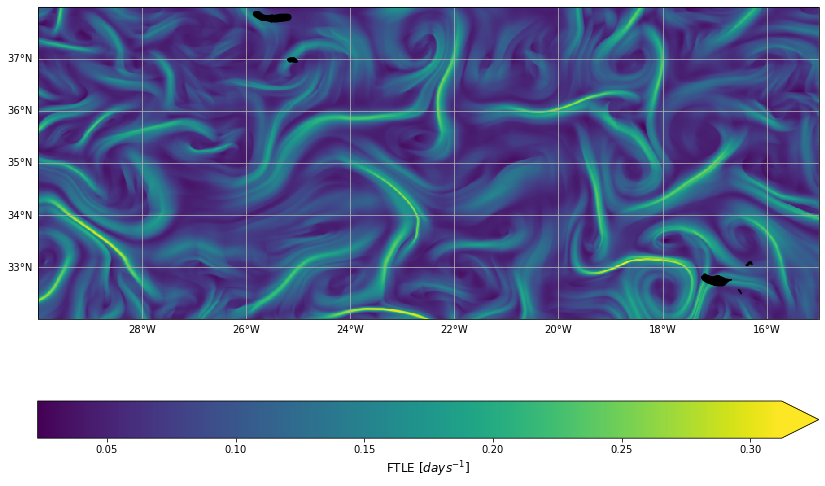

In [10]:
grid_lons = lons
grid_lats = lats


fig = plt.figure(figsize=(14, 10)) #(17,5)
ax1 = plt.subplot(111, projection=ccrs.PlateCarree())

cc = ax1.pcolor(grid_lons, grid_lats, FTLE_f_1_64grid_15d, cmap='viridis', transform=ccrs.PlateCarree()) # , vmin=0., vmax=0.7#marker='o'

ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black', zorder=20)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


cbar = plt.colorbar(cc, extend='max', orientation='horizontal') #, cax=axC)
cbar.set_label('FTLE [$days^{-1}$]', size=12)

plt.show()